In [1]:
from tqdm import tqdm, tqdm_notebook
import pickle

import pandas as pd
import numpy as np

import spacy
from gensim.models import Phrases
from gensim import models,corpora
from gensim.models.coherencemodel import CoherenceModel
import pyLDAvis.gensim

from pathlib import Path
from multiprocessing import Pool, cpu_count
from dask import dataframe as dd
from dask.multiprocessing import get

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split

In [2]:
nCores = cpu_count()

In [3]:
import warnings
import logging
warnings.filterwarnings('ignore')

In [4]:
PATH = Path('data/')
list(PATH.iterdir())

[PosixPath('data/tokenized_text_train.pkl'),
 PosixPath('data/tokenized_text_test.pkl'),
 PosixPath('data/train.tsv'),
 PosixPath('data/test.tsv'),
 PosixPath('data/processed_bigram_descriptions.pkl'),
 PosixPath('data/doc_term_matrix.pkl'),
 PosixPath('data/dictionary.pkl')]

In [5]:
train_df = pd.read_csv(PATH/'train.tsv',sep = '\t')

In [6]:
test_df = pd.read_csv(PATH/'test.tsv',sep = '\t')

## Get Detailed Product Description

In [23]:
def merge_strings(x):
    return (str(x.item_description) if x.item_description else 'No description yet') +\
        ' ' + (str(x.name) if x.name else ' ') +\
        ' ' + (str(x.category_name) if x.category_name else ' ')

In [30]:
train_df['complete_description'] = \
    dd.from_pandas(train_df, npartitions=nCores).\
        map_partitions(
            lambda df : df.apply(
                lambda x : merge_strings(x), axis=1)).\
        compute(get=get)

In [31]:
test_df['complete_description'] = \
    dd.from_pandas(test_df, npartitions=nCores).\
        map_partitions(
            lambda df : df.apply(
                lambda x : merge_strings(x), axis=1)).\
        compute(get=get)

## Processing Descriptions

In [33]:
nlp = spacy.load('en')

### Tokenize Text

In [36]:
def tokenize_text(df_col):
    text_corpus = df_col.apply(lambda x: str(x).lower()).values
    removal=['ADV', 'PRON', 'CCONJ', 'PUNCT', 'PART', 'DET',
             'ADP','SPACE','VERB']
    text_out_final = []

    for review in tqdm_notebook(nlp.pipe(text_corpus, n_threads=16, batch_size=10000),
                                desc='Tokenizing'):
        text_out = []
        for token in review:
            if token.pos_ not in removal and token.is_punct == False and token.is_stop == False:
                lemma = token.lemma_
                if lemma != '-PRON-':
                    text_out.append(lemma)

        text_out_final.append(text_out)
    return text_out_final

In [37]:
tokenized_text = tokenize_text(train_df['complete_description'])

A Jupyter Widget

In [38]:
tokenized_text_test = tokenize_text(test_df['complete_description'])

A Jupyter Widget

In [39]:
with open('data/tokenized_text_train.pkl', 'wb') as f:
    pickle.dump(tokenized_text, f)

with open('data/tokenized_text_test.pkl', 'wb') as f:
    pickle.dump(tokenized_text_test, f)

In [40]:
review_len_test = [len(x) for x in tokenized_text_test]
review_len = [len(x) for x in tokenized_text]
np.percentile(review_len, 95)

52.0

### Create Bi-grams

In [41]:
bigram_model = Phrases(tokenized_text, scoring='npmi', threshold=0.5, min_count=100)
# what's threshold?
# scoring types, what's the difference
# threshold - number of times the bigram occurs?

In [42]:
def generate_bigrams(review):
    return bigram_model[review]

In [43]:
p = Pool(24)
processed_bigram_descriptions = p.map(generate_bigrams, tokenized_text)

In [48]:
with open('data/processed_bigram_descriptions.pkl', 'wb') as f:
    pickle.dump(processed_bigram_descriptions, f)

### Build Dictionary and Doc Term Matrix

In [44]:
dictionary = corpora.Dictionary(processed_bigram_descriptions)

In [49]:
with open('data/dictionary.pkl', 'wb') as f:
    pickle.dump(dictionary, f)

In [45]:
doc_term_matrix = p.map(dictionary.doc2bow, processed_bigram_descriptions)

In [50]:
with open('data/doc_term_matrix.pkl', 'wb') as f:
    pickle.dump(doc_term_matrix, f)

## Topic Modeling

In [5]:
with open('data/tokenized_text_train.pkl', 'rb') as f:
    tokenized_text_train = pickle.load(f)

with open('data/tokenized_text_test.pkl', 'rb') as f:
    tokenized_text_test = pickle.load(f)

In [6]:
with open('data/processed_bigram_descriptions.pkl', 'rb') as f:
    processed_bigram_descriptions = pickle.load(f)
    
with open('data/dictionary.pkl', 'rb') as f:
    dictionary = pickle.load(f)
    
with open('data/doc_term_matrix.pkl', 'rb') as f:
    doc_term_matrix = pickle.load(f)

In [7]:
Lda = models.LdaMulticore
coherenceList_umass = []
num_topics_list = np.arange(5,30,5)
for num_topics in tqdm_notebook(num_topics_list):
    lda= Lda(doc_term_matrix, num_topics=num_topics, id2word = dictionary, 
             passes=3, chunksize=8000, random_state=42)
    cm = CoherenceModel(model=lda, corpus=doc_term_matrix, 
                        dictionary=dictionary, coherence='u_mass')
    coherenceList_umass.append(cm.get_coherence())
    vis = pyLDAvis.gensim.prepare(lda, doc_term_matrix, dictionary)
    pyLDAvis.save_html(vis, f'pyLDAvis_{num_topics}.html')
logging.basicConfig(format='%(levelname)s : %(message)s', level=logging.DEBUG)

A Jupyter Widget

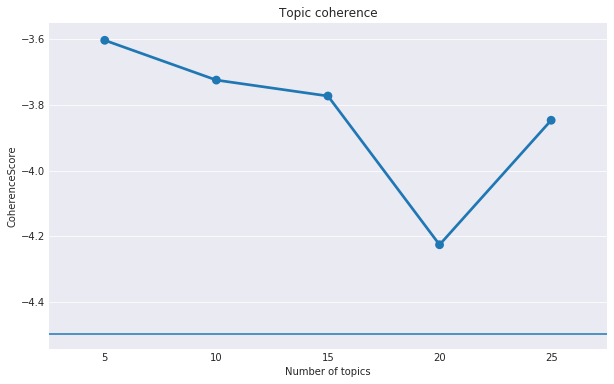

In [10]:
plotData = pd.DataFrame({'Number of topics': num_topics_list,
                         'CoherenceScore': coherenceList_umass})
f,ax = plt.subplots(figsize=(10,6))
sns.set_style("darkgrid")
sns.pointplot(x='Number of topics', y= 'CoherenceScore', data=plotData)
plt.axhline(y=-4.5)
plt.title('Topic coherence')
plt.show();
plt.savefig('topic_coherence_plot.png')

### Final Model

In [16]:
logger = logging.Logger('logger')
logger.setLevel(logging.CRITICAL)

In [17]:
num_topics =20
Lda = models.LdaMulticore
lda= Lda(doc_term_matrix, num_topics=num_topics, id2word = dictionary, 
             passes=3, chunksize=8000, random_state=42)
cm = CoherenceModel(model=lda, corpus=doc_term_matrix, 
                        dictionary=dictionary, coherence='u_mass')

INFO : using symmetric alpha at 0.05
INFO : using symmetric eta at 0.05
INFO : using serial LDA version on this node
INFO : running online LDA training, 20 topics, 3 passes over the supplied corpus of 1482535 documents, updating every 24000 documents, evaluating every ~240000 documents, iterating 50x with a convergence threshold of 0.001000
INFO : training LDA model using 3 processes
DEBUG : worker process entering E-step loop
DEBUG : getting a new job
DEBUG : worker process entering E-step loop
DEBUG : getting a new job
DEBUG : worker process entering E-step loop
DEBUG : getting a new job
INFO : PROGRESS: pass 0, dispatched chunk #0 = documents up to #8000/1482535, outstanding queue size 1
INFO : PROGRESS: pass 0, dispatched chunk #1 = documents up to #16000/1482535, outstanding queue size 2
INFO : PROGRESS: pass 0, dispatched chunk #2 = documents up to #24000/1482535, outstanding queue size 3
INFO : PROGRESS: pass 0, dispatched chunk #3 = documents up to #32000/1482535, outstanding q

INFO : topic #9 (0.050): 0.016*"1" + 0.015*"brand_new" + 0.010*"new" + 0.009*"size" + 0.008*"case" + 0.007*"2" + 0.007*"color" + 0.006*"beauty_makeup" + 0.006*"free" + 0.006*"rm"
INFO : topic diff=0.073711, rho=0.316228
INFO : PROGRESS: pass 0, dispatched chunk #13 = documents up to #112000/1482535, outstanding queue size 2
INFO : PROGRESS: pass 0, dispatched chunk #14 = documents up to #120000/1482535, outstanding queue size 2
INFO : PROGRESS: pass 0, dispatched chunk #15 = documents up to #128000/1482535, outstanding queue size 3
INFO : PROGRESS: pass 0, dispatched chunk #16 = documents up to #136000/1482535, outstanding queue size 4
INFO : PROGRESS: pass 0, dispatched chunk #17 = documents up to #144000/1482535, outstanding queue size 5
INFO : PROGRESS: pass 0, dispatched chunk #18 = documents up to #152000/1482535, outstanding queue size 6
DEBUG : processing chunk #13 of 8000 documents
DEBUG : performing inference on a chunk of 8000 documents
INFO : PROGRESS: pass 0, dispatched chu

INFO : PROGRESS: pass 0, dispatched chunk #29 = documents up to #240000/1482535, outstanding queue size 6
INFO : PROGRESS: pass 0, dispatched chunk #30 = documents up to #248000/1482535, outstanding queue size 7
DEBUG : processing chunk #25 of 8000 documents
DEBUG : performing inference on a chunk of 8000 documents
INFO : PROGRESS: pass 0, dispatched chunk #31 = documents up to #256000/1482535, outstanding queue size 8
DEBUG : 7401/8000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
INFO : PROGRESS: pass 0, dispatched chunk #32 = documents up to #264000/1482535, outstanding queue size 9
DEBUG : result put
DEBUG : getting a new job
DEBUG : processing chunk #26 of 8000 documents
DEBUG : performing inference on a chunk of 8000 documents
DEBUG : 7441/8000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : performing inference on a chunk of 8000 documents
DEBUG : result put
DEBUG : getting a new job
DEBUG : proc

DEBUG : performing inference on a chunk of 8000 documents
DEBUG : result put
DEBUG : getting a new job
DEBUG : processing chunk #38 of 8000 documents
DEBUG : 7653/8000 documents converged within 50 iterations
DEBUG : performing inference on a chunk of 8000 documents
DEBUG : updating topics
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
INFO : merging changes from 24000 documents into a model of 1482535 documents
DEBUG : processing chunk #39 of 8000 documents
DEBUG : performing inference on a chunk of 8000 documents
DEBUG : performing inference on a chunk of 8000 documents
DEBUG : 7616/8000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : processing chunk #40 of 8000 documents
DEBUG : 7624/8000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 7626/8000 documents converge

DEBUG : 7721/8000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 7745/8000 documents converged within 50 iterations
DEBUG : result put
DEBUG : getting a new job
INFO : topic #7 (0.050): 0.040*"rm" + 0.019*"2" + 0.017*"3" + 0.015*"1" + 0.014*"item" + 0.013*"color" + 0.013*"shipping" + 0.010*"day" + 0.009*"free" + 0.009*"4"
INFO : topic #2 (0.050): 0.052*"beauty_makeup" + 0.021*"bra" + 0.018*"face" + 0.017*"brand_new" + 0.016*"lip" + 0.014*"color" + 0.013*"new" + 0.012*"eye" + 0.012*"size" + 0.011*"makeup"
INFO : topic #16 (0.050): 0.086*"woman_top" + 0.059*"shirt" + 0.046*"blouse" + 0.040*"blouse_t" + 0.030*"size" + 0.015*"blouse_tank" + 0.015*"small" + 0.012*"medium" + 0.009*"large" + 0.008*"description"
INFO : topic #11 (0.050): 0.058*"man" + 0.052*"woman" + 0.042*"size" + 0.016*"shirt" + 0.013*"shoe" + 0.012*"jean" + 0.010*"new" + 0.010*"skinny" + 0.0

INFO : topic diff=0.054818, rho=0.129099
INFO : PROGRESS: pass 0, dispatched chunk #63 = documents up to #512000/1482535, outstanding queue size 2
INFO : PROGRESS: pass 0, dispatched chunk #64 = documents up to #520000/1482535, outstanding queue size 2
INFO : PROGRESS: pass 0, dispatched chunk #65 = documents up to #528000/1482535, outstanding queue size 3
INFO : PROGRESS: pass 0, dispatched chunk #66 = documents up to #536000/1482535, outstanding queue size 4DEBUG : processing chunk #63 of 8000 documents
DEBUG : performing inference on a chunk of 8000 documents

INFO : PROGRESS: pass 0, dispatched chunk #67 = documents up to #544000/1482535, outstanding queue size 5
INFO : PROGRESS: pass 0, dispatched chunk #68 = documents up to #552000/1482535, outstanding queue size 6
INFO : PROGRESS: pass 0, dispatched chunk #69 = documents up to #560000/1482535, outstanding queue size 7
DEBUG : processing chunk #64 of 8000 documents
DEBUG : performing inference on a chunk of 8000 documents
INFO : 

DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : processing chunk #79 of 8000 documents
DEBUG : performing inference on a chunk of 8000 documents
DEBUG : updating topics
DEBUG : processing chunk #80 of 8000 documents
DEBUG : performing inference on a chunk of 8000 documents
INFO : merging changes from 40000 documents into a model of 1482535 documents
DEBUG : 7824/8000 documents converged within 50 iterations
DEBUG : getting a new job
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 7811/8000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
INFO : topic #9 (0.050): 0.039*"case" + 0.026*"phone_accessory" + 0.026*"electronic_cell" + 0.021*"case_skin" + 0.015*"book" + 0.013*"1" + 0.011*"brand_new" + 0.010*"phone" + 0.009*"new" + 0.008*"iphone"
INFO : topic #7 (0.050): 0.046*"rm" + 0.021*"2" + 0.019*"3" + 0.018*"1" + 0.018*"item" + 0.016*"shipping" + 0.013*"color" + 0

INFO : topic #6 (0.050): 0.075*"woman" + 0.034*"size" + 0.018*"shoe" + 0.012*"condition" + 0.012*"coat_jacket" + 0.011*"small" + 0.010*"new" + 0.009*"black" + 0.009*"perfect" + 0.009*"sweater"
INFO : topic #14 (0.050): 0.043*"woman_athletic" + 0.038*"size" + 0.023*"tight_legging" + 0.023*"apparel_pant" + 0.018*"legging" + 0.016*"shirt" + 0.015*"apparel" + 0.013*"black" + 0.013*"pink" + 0.013*"pant"
INFO : topic diff=0.065861, rho=0.108465
INFO : PROGRESS: pass 0, dispatched chunk #91 = documents up to #736000/1482535, outstanding queue size 4
DEBUG : updating topics
INFO : merging changes from 24000 documents into a model of 1482535 documents
DEBUG : processing chunk #91 of 8000 documents
DEBUG : performing inference on a chunk of 8000 documents
DEBUG : 7836/8000 documents converged within 50 iterations
DEBUG : getting a new job
DEBUG : processed chunk, queuing the result
DEBUG : result put
INFO : topic #19 (0.050): 0.037*"woman" + 0.020*"woman_handbag" + 0.016*"bag" + 0.016*"size" + 0

DEBUG : getting a new job
DEBUG : processed chunk, queuing the result
DEBUG : result put
INFO : topic #2 (0.050): 0.060*"beauty_makeup" + 0.023*"lip" + 0.022*"bra" + 0.021*"face" + 0.019*"brand_new" + 0.018*"color" + 0.017*"eye" + 0.014*"new" + 0.012*"makeup" + 0.012*"woman_underwear"
INFO : topic #4 (0.050): 0.029*"woman" + 0.024*"beauty_fragrance" + 0.022*"brand_new" + 0.014*"new" + 0.013*"pantie" + 0.012*"bath_body" + 0.012*"woman_underwear" + 0.011*"item" + 0.010*"bottle" + 0.010*"beauty_skin"
INFO : topic #9 (0.050): 0.044*"case" + 0.029*"phone_accessory" + 0.029*"electronic_cell" + 0.023*"case_skin" + 0.015*"book" + 0.011*"phone" + 0.011*"brand_new" + 0.011*"1" + 0.009*"new" + 0.009*"iphone"
INFO : topic #0 (0.050): 0.019*"item" + 0.015*"electronic" + 0.012*"free" + 0.010*"medium_dvd" + 0.010*"blue" + 0.010*"color" + 0.010*"price" + 0.009*"cm" + 0.009*"free_shipping" + 0.009*"size"
INFO : topic #17 (0.050): 0.051*"description" + 0.038*"kid_boy" + 0.036*"kid_girl" + 0.033*"0_24" +

DEBUG : processed chunk, queuing the result
DEBUG : performing inference on a chunk of 8000 documents
DEBUG : 7890/8000 documents converged within 50 iterations
INFO : PROGRESS: pass 0, dispatched chunk #120 = documents up to #968000/1482535, outstanding queue size 7
INFO : PROGRESS: pass 0, dispatched chunk #121 = documents up to #976000/1482535, outstanding queue size 8
DEBUG : result put
DEBUG : getting a new job
DEBUG : processing chunk #116 of 8000 documents
DEBUG : getting a new job
DEBUG : performing inference on a chunk of 8000 documents
DEBUG : 7885/8000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : 7881/8000 documents converged within 50 iterations
DEBUG : performing inference on a chunk of 8000 documents
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : processing chunk #117 of 8000 documents
DEBUG : updating topics
DEBUG : processing chunk #118 of 8000 documents


DEBUG : 7884/8000 documents converged within 50 iterations
DEBUG : getting a new job
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : processing chunk #129 of 8000 documents
DEBUG : performing inference on a chunk of 8000 documents
DEBUG : processing chunk #130 of 8000 documents
DEBUG : 7894/8000 documents converged within 50 iterations
DEBUG : performing inference on a chunk of 8000 documents
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 7886/8000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : updating topics
DEBUG : result put
DEBUG : getting a new job
INFO : merging changes from 40000 documents into a model of 1482535 documents
DEBUG : processing chunk #131 of 8000 documents
DEBUG : performing inference on a chunk of 8000 documents
DEBUG : 7877/8000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : gettin

INFO : topic #17 (0.050): 0.055*"description" + 0.041*"kid_girl" + 0.040*"kid_boy" + 0.033*"0_24" + 0.029*"size" + 0.024*"mo" + 0.017*"shoe" + 0.016*"kid_toy" + 0.016*"girl" + 0.015*"2t-5t_shoe"
INFO : topic #11 (0.050): 0.081*"man" + 0.047*"woman" + 0.045*"size" + 0.020*"jean" + 0.018*"shoe" + 0.014*"athletic" + 0.014*"skinny" + 0.013*"shirt" + 0.012*"sneaker" + 0.010*"new"
INFO : topic #2 (0.050): 0.062*"beauty_makeup" + 0.025*"lip" + 0.022*"bra" + 0.021*"face" + 0.019*"brand_new" + 0.019*"color" + 0.019*"eye" + 0.015*"new" + 0.013*"makeup" + 0.011*"brush"
INFO : topic #8 (0.050): 0.043*"woman_jewelry" + 0.028*"necklace" + 0.020*"ring" + 0.020*"bracelet" + 0.016*"accessory" + 0.016*"gold" + 0.016*"earring" + 0.013*"silver" + 0.013*"jewelry" + 0.010*"tool"
INFO : topic diff=0.060801, rho=0.084819
INFO : PROGRESS: pass 0, dispatched chunk #142 = documents up to #1144000/1482535, outstanding queue size 2
INFO : PROGRESS: pass 0, dispatched chunk #143 = documents up to #1152000/1482535, 

INFO : topic #3 (0.050): 0.025*"kid_toy" + 0.014*"vintage_collectible" + 0.013*"skin" + 0.011*"beauty_skin" + 0.011*"box" + 0.009*"care_face" + 0.009*"new" + 0.008*"brand_new" + 0.008*"action_figure" + 0.007*"statue"
INFO : topic diff=0.073365, rho=0.081650
INFO : PROGRESS: pass 0, dispatched chunk #154 = documents up to #1240000/1482535, outstanding queue size 2
INFO : PROGRESS: pass 0, dispatched chunk #155 = documents up to #1248000/1482535, outstanding queue size 2
INFO : PROGRESS: pass 0, dispatched chunk #156 = documents up to #1256000/1482535, outstanding queue size 3
INFO : PROGRESS: pass 0, dispatched chunk #157 = documents up to #1264000/1482535, outstanding queue size 4
INFO : PROGRESS: pass 0, dispatched chunk #158 = documents up to #1272000/1482535, outstanding queue size 5DEBUG : processing chunk #154 of 8000 documents
DEBUG : performing inference on a chunk of 8000 documents

INFO : PROGRESS: pass 0, dispatched chunk #159 = documents up to #1280000/1482535, outstanding q

DEBUG : processing chunk #168 of 8000 documents
INFO : topic #11 (0.050): 0.084*"man" + 0.046*"woman" + 0.045*"size" + 0.020*"jean" + 0.019*"shoe" + 0.015*"athletic" + 0.014*"skinny" + 0.012*"shirt" + 0.012*"sneaker" + 0.011*"new"
INFO : topic #10 (0.050): 0.027*"care" + 0.024*"daily_travel" + 0.024*"nail" + 0.013*"woman_athletic" + 0.013*"new" + 0.013*"audio_surveillance" + 0.013*"electronic_tv" + 0.012*"item_personal" + 0.011*"description" + 0.010*"brand_new"
INFO : topic #9 (0.050): 0.050*"case" + 0.033*"phone_accessory" + 0.033*"electronic_cell" + 0.025*"case_skin" + 0.015*"book" + 0.013*"phone" + 0.011*"brand_new" + 0.010*"iphone" + 0.009*"new" + 0.009*"iphone_6"
INFO : topic #13 (0.050): 0.028*"accessory" + 0.022*"home_kitchen" + 0.022*"woman" + 0.017*"hair" + 0.016*"item" + 0.012*"inch" + 0.011*"✨" + 0.010*"tea_accessory" + 0.010*"dining_coffee" + 0.010*"brand_new"
INFO : topic #14 (0.050): 0.053*"woman_athletic" + 0.038*"size" + 0.027*"tight_legging" + 0.027*"apparel_pant" + 0.

INFO : topic #12 (0.050): 0.052*"woman" + 0.037*"size" + 0.029*"dress" + 0.018*"dress_knee" + 0.018*"length" + 0.016*"mini" + 0.014*"black" + 0.014*"small" + 0.011*"tag" + 0.009*"medium"
INFO : topic #18 (0.050): 0.036*"accessory" + 0.024*"cell_phone" + 0.022*"phone_accessory" + 0.022*"electronic_cell" + 0.017*"phone" + 0.014*"smartphone" + 0.014*"charger" + 0.013*"battery" + 0.010*"camera" + 0.010*"new"
INFO : topic #6 (0.050): 0.091*"woman" + 0.036*"size" + 0.019*"shoe" + 0.012*"sweater" + 0.012*"coat_jacket" + 0.011*"black" + 0.011*"condition" + 0.010*"shoe_boot" + 0.010*"new" + 0.009*"small"
INFO : topic #16 (0.050): 0.093*"woman_top" + 0.076*"shirt" + 0.050*"blouse" + 0.041*"blouse_t" + 0.036*"size" + 0.019*"small" + 0.018*"blouse_tank" + 0.014*"medium" + 0.012*"large" + 0.010*"tank"
INFO : topic diff=0.064261, rho=0.075378
INFO : PROGRESS: pass 0, dispatched chunk #182 = documents up to #1464000/1482535, outstanding queue size 5
DEBUG : updating topics
DEBUG : processing chunk #1

INFO : topic #4 (0.050): 0.026*"beauty_fragrance" + 0.025*"woman" + 0.021*"brand_new" + 0.016*"new" + 0.015*"bath_body" + 0.014*"pantie" + 0.014*"bottle" + 0.014*"woman_underwear" + 0.013*"oz" + 0.012*"beauty"
INFO : topic #18 (0.050): 0.037*"accessory" + 0.025*"cell_phone" + 0.022*"phone_accessory" + 0.022*"electronic_cell" + 0.017*"phone" + 0.014*"smartphone" + 0.014*"charger" + 0.013*"battery" + 0.011*"camera" + 0.010*"new"
INFO : topic #11 (0.050): 0.086*"man" + 0.045*"size" + 0.045*"woman" + 0.022*"jean" + 0.019*"shoe" + 0.015*"athletic" + 0.014*"skinny" + 0.012*"sneaker" + 0.012*"shirt" + 0.011*"new"
INFO : topic #7 (0.050): 0.055*"rm" + 0.029*"item" + 0.025*"shipping" + 0.024*"2" + 0.023*"1" + 0.020*"3" + 0.018*"price" + 0.017*"day" + 0.013*"listing" + 0.013*"free"
INFO : topic diff=0.048433, rho=0.073065
INFO : PROGRESS: pass 1, dispatched chunk #9 = documents up to #80000/1482535, outstanding queue size 3
DEBUG : processing chunk #9 of 8000 documents
DEBUG : performing inferen

INFO : PROGRESS: pass 1, dispatched chunk #23 = documents up to #192000/1482535, outstanding queue size 5
INFO : PROGRESS: pass 1, dispatched chunk #24 = documents up to #200000/1482535, outstanding queue size 6
DEBUG : processing chunk #19 of 8000 documents
DEBUG : performing inference on a chunk of 8000 documents
INFO : PROGRESS: pass 1, dispatched chunk #25 = documents up to #208000/1482535, outstanding queue size 7
DEBUG : processing chunk #20 of 8000 documents
DEBUG : performing inference on a chunk of 8000 documents
INFO : PROGRESS: pass 1, dispatched chunk #26 = documents up to #216000/1482535, outstanding queue size 8
DEBUG : 7936/8000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : performing inference on a chunk of 8000 documents
DEBUG : getting a new job
DEBUG : 7941/8000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : proc

INFO : topic #6 (0.050): 0.093*"woman" + 0.037*"size" + 0.019*"shoe" + 0.012*"sweater" + 0.012*"coat_jacket" + 0.011*"shoe_boot" + 0.011*"black" + 0.011*"condition" + 0.010*"new" + 0.010*"small"
INFO : topic #11 (0.050): 0.086*"man" + 0.046*"woman" + 0.045*"size" + 0.021*"jean" + 0.019*"shoe" + 0.015*"athletic" + 0.014*"skinny" + 0.012*"sneaker" + 0.012*"shirt" + 0.011*"new"
INFO : topic diff=0.038612, rho=0.073065
INFO : PROGRESS: pass 1, dispatched chunk #37 = documents up to #304000/1482535, outstanding queue size 8
DEBUG : processing chunk #34 of 8000 documents
DEBUG : performing inference on a chunk of 8000 documents
DEBUG : 7934/8000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : performing inference on a chunk of 8000 documents
DEBUG : getting a new job
DEBUG : processing chunk #35 of 8000 documents
DEBUG : 7951/8000 documents converged within 50 iterations
DEBUG : performing inference on a chunk of 8000 documents


INFO : PROGRESS: pass 1, dispatched chunk #49 = documents up to #400000/1482535, outstanding queue size 4
INFO : PROGRESS: pass 1, dispatched chunk #50 = documents up to #408000/1482535, outstanding queue size 5
INFO : PROGRESS: pass 1, dispatched chunk #51 = documents up to #416000/1482535, outstanding queue size 6
INFO : PROGRESS: pass 1, dispatched chunk #52 = documents up to #424000/1482535, outstanding queue size 7
DEBUG : processing chunk #47 of 8000 documents
DEBUG : performing inference on a chunk of 8000 documents
DEBUG : 7956/8000 documents converged within 50 iterations
INFO : PROGRESS: pass 1, dispatched chunk #53 = documents up to #432000/1482535, outstanding queue size 8
DEBUG : processed chunk, queuing the result
DEBUG : getting a new job
DEBUG : result put
DEBUG : updating topics
DEBUG : 7941/8000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : processing chunk #48 of 8000 documents
DEBUG : performing infer

DEBUG : processing chunk #60 of 8000 documents
DEBUG : performing inference on a chunk of 8000 documents
DEBUG : 7950/8000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 7940/8000 documents converged within 50 iterations
DEBUG : performing inference on a chunk of 8000 documents
DEBUG : processed chunk, queuing the result
DEBUG : processing chunk #61 of 8000 documents
DEBUG : result put
DEBUG : getting a new job
DEBUG : updating topics
DEBUG : 7953/8000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
INFO : merging changes from 40000 documents into a model of 1482535 documents
DEBUG : result put
DEBUG : getting a new job
DEBUG : processing chunk #62 of 8000 documents
DEBUG : performing inference on a chunk of 8000 documents
DEBUG : 7954/8000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a

DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
INFO : topic #16 (0.050): 0.094*"woman_top" + 0.077*"shirt" + 0.051*"blouse" + 0.041*"blouse_t" + 0.036*"size" + 0.019*"small" + 0.018*"blouse_tank" + 0.015*"medium" + 0.012*"large" + 0.011*"tank"
INFO : topic #6 (0.050): 0.093*"woman" + 0.037*"size" + 0.019*"shoe" + 0.012*"sweater" + 0.012*"coat_jacket" + 0.011*"shoe_boot" + 0.011*"black" + 0.011*"condition" + 0.010*"new" + 0.010*"small"
INFO : topic #1 (0.050): 0.081*"home" + 0.051*"home_décor" + 0.022*"accent" + 0.010*"cable" + 0.009*"brand_new" + 0.008*"new" + 0.007*"decor" + 0.007*"phone_accessory" + 0.007*"electronic_cell" + 0.007*"iphone"
INFO : topic #17 (0.050): 0.055*"description" + 0.046*"kid_girl" + 0.041*"kid_boy" + 0.032*"0_24" + 0.031*"size" + 0.022*"mo" + 0.018*"girl" + 0.015*"shoe" + 0.014*"2t-5t_shoe" + 0.013*"baby"
INFO : topic #8 (0.050): 0.043*"woman_jewelry" + 0.028*"necklace" + 0.021*"bracelet" + 0.021*"ring" + 0.017*"gold" +

INFO : topic #17 (0.050): 0.054*"description" + 0.046*"kid_girl" + 0.041*"kid_boy" + 0.031*"size" + 0.031*"0_24" + 0.022*"mo" + 0.018*"girl" + 0.015*"shoe" + 0.015*"2t-5t_shoe" + 0.013*"shirt"
INFO : topic diff=0.034087, rho=0.073065
INFO : PROGRESS: pass 1, dispatched chunk #85 = documents up to #688000/1482535, outstanding queue size 2
INFO : PROGRESS: pass 1, dispatched chunk #86 = documents up to #696000/1482535, outstanding queue size 2
INFO : PROGRESS: pass 1, dispatched chunk #87 = documents up to #704000/1482535, outstanding queue size 3
INFO : PROGRESS: pass 1, dispatched chunk #88 = documents up to #712000/1482535, outstanding queue size 4
INFO : PROGRESS: pass 1, dispatched chunk #89 = documents up to #720000/1482535, outstanding queue size 5
INFO : PROGRESS: pass 1, dispatched chunk #90 = documents up to #728000/1482535, outstanding queue size 6
DEBUG : processing chunk #85 of 8000 documents
DEBUG : performing inference on a chunk of 8000 documents
INFO : PROGRESS: pass 1, 

DEBUG : result put
DEBUG : getting a new job
DEBUG : processing chunk #96 of 8000 documents
DEBUG : performing inference on a chunk of 8000 documents
DEBUG : 7962/8000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : performing inference on a chunk of 8000 documents
DEBUG : getting a new job
DEBUG : processing chunk #97 of 8000 documents
DEBUG : updating topics
DEBUG : processing chunk #98 of 8000 documents
DEBUG : performing inference on a chunk of 8000 documents
DEBUG : 7958/8000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
INFO : merging changes from 24000 documents into a model of 1482535 documents
DEBUG : result put
DEBUG : getting a new job
DEBUG : 7969/8000 documents converged within 50 iterations
DEBUG : getting a new job
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : processing chunk #99 of 8000 documents
DEBUG : performing inference on a chunk of 8000

DEBUG : performing inference on a chunk of 8000 documents
DEBUG : getting a new job
DEBUG : processing chunk #110 of 8000 documents
INFO : merging changes from 40000 documents into a model of 1482535 documents
DEBUG : processing chunk #111 of 8000 documents
DEBUG : getting a new job
DEBUG : performing inference on a chunk of 8000 documents
DEBUG : 7956/8000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 7952/8000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : processing chunk #112 of 8000 documents
DEBUG : performing inference on a chunk of 8000 documents
DEBUG : processed chunk, queuing the result
DEBUG : 7968/8000 documents converged within 50 iterations
DEBUG : result put
DEBUG : getting a new job
INFO : topic #11 (0.050): 0.089*"man" + 0.046*"woman" + 0.045*"size" + 0.022*"jean" + 0.019*"shoe" + 0.015*"athletic" + 0.014*"skinny"

INFO : topic #8 (0.050): 0.043*"woman_jewelry" + 0.028*"necklace" + 0.021*"ring" + 0.021*"bracelet" + 0.018*"gold" + 0.016*"accessory" + 0.016*"earring" + 0.015*"silver" + 0.014*"jewelry" + 0.010*"tool"
INFO : topic #6 (0.050): 0.094*"woman" + 0.037*"size" + 0.019*"shoe" + 0.013*"sweater" + 0.012*"coat_jacket" + 0.011*"shoe_boot" + 0.011*"black" + 0.010*"condition" + 0.010*"new" + 0.010*"boot"
INFO : topic #9 (0.050): 0.055*"case" + 0.034*"phone_accessory" + 0.034*"electronic_cell" + 0.025*"case_skin" + 0.015*"book" + 0.014*"phone" + 0.011*"brand_new" + 0.010*"iphone" + 0.009*"new" + 0.009*"iphone_6"
INFO : topic #15 (0.050): 0.094*"game" + 0.063*"electronic_video" + 0.060*"game_console" + 0.015*"kid" + 0.014*"dog" + 0.011*"new" + 0.010*"console" + 0.009*"great" + 0.008*"accessory" + 0.008*"2"
INFO : topic diff=0.034132, rho=0.073065
INFO : PROGRESS: pass 1, dispatched chunk #124 = documents up to #1000000/1482535, outstanding queue size 5
DEBUG : updating topics
DEBUG : processing chu

INFO : PROGRESS: pass 1, dispatched chunk #137 = documents up to #1104000/1482535, outstanding queue size 4
INFO : PROGRESS: pass 1, dispatched chunk #138 = documents up to #1112000/1482535, outstanding queue size 5
INFO : PROGRESS: pass 1, dispatched chunk #139 = documents up to #1120000/1482535, outstanding queue size 6
DEBUG : processing chunk #134 of 8000 documents
DEBUG : performing inference on a chunk of 8000 documents
INFO : PROGRESS: pass 1, dispatched chunk #140 = documents up to #1128000/1482535, outstanding queue size 7
DEBUG : processing chunk #135 of 8000 documents
INFO : PROGRESS: pass 1, dispatched chunk #141 = documents up to #1136000/1482535, outstanding queue size 8DEBUG : processed chunk, queuing the result
DEBUG : performing inference on a chunk of 8000 documents

DEBUG : 7958/8000 documents converged within 50 iterations
DEBUG : result put
DEBUG : performing inference on a chunk of 8000 documents
DEBUG : getting a new job
DEBUG : 7947/8000 documents converged with

DEBUG : processed chunk, queuing the result
DEBUG : result put
INFO : topic #9 (0.050): 0.056*"case" + 0.034*"phone_accessory" + 0.034*"electronic_cell" + 0.026*"case_skin" + 0.015*"phone" + 0.015*"book" + 0.012*"brand_new" + 0.010*"iphone" + 0.009*"iphone_6" + 0.009*"new"
INFO : topic #18 (0.050): 0.038*"accessory" + 0.025*"cell_phone" + 0.023*"phone_accessory" + 0.022*"electronic_cell" + 0.018*"phone" + 0.015*"smartphone" + 0.014*"battery" + 0.014*"charger" + 0.011*"camera" + 0.010*"new"
INFO : topic #16 (0.050): 0.092*"woman_top" + 0.076*"shirt" + 0.049*"blouse" + 0.040*"blouse_t" + 0.037*"size" + 0.020*"small" + 0.018*"blouse_tank" + 0.015*"medium" + 0.012*"large" + 0.011*"tank"
INFO : topic #7 (0.050): 0.057*"rm" + 0.035*"item" + 0.029*"shipping" + 0.024*"2" + 0.023*"1" + 0.022*"price" + 0.019*"3" + 0.018*"day" + 0.016*"listing" + 0.015*"free"
INFO : topic #17 (0.050): 0.054*"description" + 0.046*"kid_girl" + 0.040*"kid_boy" + 0.033*"size" + 0.030*"0_24" + 0.021*"mo" + 0.019*"girl

INFO : topic #7 (0.050): 0.057*"rm" + 0.035*"item" + 0.029*"shipping" + 0.024*"2" + 0.023*"1" + 0.022*"price" + 0.019*"3" + 0.018*"day" + 0.016*"listing" + 0.015*"free"
INFO : topic diff=0.036340, rho=0.073065
INFO : PROGRESS: pass 1, dispatched chunk #162 = documents up to #1304000/1482535, outstanding queue size 3
DEBUG : processing chunk #162 of 8000 documents
DEBUG : performing inference on a chunk of 8000 documents
INFO : PROGRESS: pass 1, dispatched chunk #163 = documents up to #1312000/1482535, outstanding queue size 2
INFO : PROGRESS: pass 1, dispatched chunk #164 = documents up to #1320000/1482535, outstanding queue size 3
INFO : PROGRESS: pass 1, dispatched chunk #165 = documents up to #1328000/1482535, outstanding queue size 4
INFO : PROGRESS: pass 1, dispatched chunk #166 = documents up to #1336000/1482535, outstanding queue size 5
INFO : PROGRESS: pass 1, dispatched chunk #167 = documents up to #1344000/1482535, outstanding queue size 6
INFO : PROGRESS: pass 1, dispatched 

DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 7961/8000 documents converged within 50 iterations
DEBUG : getting a new job
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : processing chunk #174 of 8000 documents
DEBUG : performing inference on a chunk of 8000 documents
DEBUG : 7967/8000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : updating topics
DEBUG : result put
DEBUG : getting a new job
DEBUG : processing chunk #175 of 8000 documents
DEBUG : performing inference on a chunk of 8000 documents
DEBUG : 7962/8000 documents converged within 50 iterations
DEBUG : performing inference on a chunk of 8000 documents
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : processing chunk #176 of 8000 documents
DEBUG : getting a new job
INFO : merging changes from 32000 documents into a model of 1482535 documents
DEBUG : 7965/8000 documents converged within 50

INFO : topic #3 (0.050): 0.027*"kid_toy" + 0.016*"vintage_collectible" + 0.013*"skin" + 0.011*"box" + 0.010*"beauty_skin" + 0.009*"care_face" + 0.009*"new" + 0.009*"brand_new" + 0.008*"2" + 0.007*"action_figure"
INFO : topic #14 (0.050): 0.062*"woman_athletic" + 0.038*"size" + 0.031*"tight_legging" + 0.030*"apparel_pant" + 0.023*"legging" + 0.021*"apparel" + 0.016*"pink" + 0.015*"black" + 0.014*"pant" + 0.012*"small"
INFO : topic diff=0.030374, rho=0.073065
DEBUG : bound: at document #0
INFO : -7.850 per-word bound, 230.8 perplexity estimate based on a held-out corpus of 2535 documents with 39813 words
INFO : PROGRESS: pass 2, dispatched chunk #0 = documents up to #8000/1482535, outstanding queue size 1
INFO : PROGRESS: pass 2, dispatched chunk #1 = documents up to #16000/1482535, outstanding queue size 2
INFO : PROGRESS: pass 2, dispatched chunk #2 = documents up to #24000/1482535, outstanding queue size 3
INFO : PROGRESS: pass 2, dispatched chunk #3 = documents up to #32000/1482535, 

INFO : topic #15 (0.050): 0.094*"game" + 0.063*"electronic_video" + 0.060*"game_console" + 0.016*"kid" + 0.015*"dog" + 0.010*"new" + 0.010*"console" + 0.009*"great" + 0.008*"accessory" + 0.007*"2"
INFO : topic #1 (0.050): 0.090*"home" + 0.051*"home_décor" + 0.022*"accent" + 0.010*"cable" + 0.010*"smoke_free" + 0.008*"brand_new" + 0.007*"new" + 0.007*"decor" + 0.006*"2" + 0.006*"wall"
INFO : topic diff=0.028117, rho=0.072871
INFO : PROGRESS: pass 2, dispatched chunk #13 = documents up to #112000/1482535, outstanding queue size 3
DEBUG : processing chunk #13 of 8000 documents
DEBUG : performing inference on a chunk of 8000 documents
INFO : PROGRESS: pass 2, dispatched chunk #14 = documents up to #120000/1482535, outstanding queue size 2
INFO : PROGRESS: pass 2, dispatched chunk #15 = documents up to #128000/1482535, outstanding queue size 3
INFO : PROGRESS: pass 2, dispatched chunk #16 = documents up to #136000/1482535, outstanding queue size 4
INFO : PROGRESS: pass 2, dispatched chunk #

INFO : topic #4 (0.050): 0.028*"beauty_fragrance" + 0.024*"woman" + 0.021*"brand_new" + 0.017*"new" + 0.017*"bottle" + 0.016*"bath_body" + 0.016*"oz" + 0.014*"beauty" + 0.014*"pantie" + 0.014*"beauty_skin"
INFO : topic #6 (0.050): 0.096*"woman" + 0.038*"size" + 0.020*"shoe" + 0.013*"sweater" + 0.012*"shoe_boot" + 0.012*"coat_jacket" + 0.011*"black" + 0.010*"boot" + 0.010*"new" + 0.010*"jacket"
INFO : topic diff=0.024844, rho=0.072871
INFO : PROGRESS: pass 2, dispatched chunk #28 = documents up to #232000/1482535, outstanding queue size 7
DEBUG : processing chunk #26 of 8000 documents
DEBUG : performing inference on a chunk of 8000 documents
DEBUG : 7965/8000 documents converged within 50 iterations
DEBUG : performing inference on a chunk of 8000 documents
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : processing chunk #27 of 8000 documents
DEBUG : updating topics
DEBUG : 7938/8000 documents converged within 50 iterations
DEBUG : process

INFO : topic #5 (0.050): 0.042*"woman" + 0.042*"bag" + 0.030*"woman_handbag" + 0.016*"pocket" + 0.015*"x" + 0.010*"purse" + 0.009*"pink" + 0.008*"leather" + 0.008*"strap" + 0.008*"black"
INFO : topic #3 (0.050): 0.027*"kid_toy" + 0.016*"vintage_collectible" + 0.013*"skin" + 0.011*"box" + 0.010*"beauty_skin" + 0.009*"new" + 0.009*"care_face" + 0.009*"brand_new" + 0.008*"action_figure" + 0.008*"2"
INFO : topic #11 (0.050): 0.091*"man" + 0.046*"woman" + 0.045*"size" + 0.024*"jean" + 0.020*"shoe" + 0.016*"athletic" + 0.015*"skinny" + 0.013*"sneaker" + 0.011*"new" + 0.011*"shirt"
INFO : topic #17 (0.050): 0.054*"description" + 0.045*"kid_girl" + 0.039*"kid_boy" + 0.034*"size" + 0.029*"0_24" + 0.021*"mo" + 0.019*"girl" + 0.016*"shirt" + 0.014*"shoe" + 0.014*"3"
INFO : topic diff=0.024107, rho=0.072871
INFO : PROGRESS: pass 2, dispatched chunk #38 = documents up to #312000/1482535, outstanding queue size 2
INFO : PROGRESS: pass 2, dispatched chunk #39 = documents up to #320000/1482535, outsta

INFO : PROGRESS: pass 2, dispatched chunk #67 = documents up to #544000/1482535, outstanding queue size 8
DEBUG : 7965/8000 documents converged within 50 iterations
DEBUG : performing inference on a chunk of 8000 documents
DEBUG : processing chunk #61 of 8000 documents
DEBUG : performing inference on a chunk of 8000 documents
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : 7963/8000 documents converged within 50 iterations
DEBUG : processing chunk #62 of 8000 documents
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : processed chunk, queuing the result
DEBUG : 7963/8000 documents converged within 50 iterations
DEBUG : result put
DEBUG : performing inference on a chunk of 8000 documents
DEBUG : getting a new job
DEBUG : processing chunk #63 of 8000 documents
DEBUG : processing chunk #64 of 8000 documents
DEBUG : processed chunk, queuing the result
DEBUG : performing inference on a chunk of 8

INFO : topic #7 (0.050): 0.057*"rm" + 0.038*"item" + 0.030*"shipping" + 0.024*"price" + 0.023*"2" + 0.022*"1" + 0.019*"3" + 0.018*"day" + 0.016*"listing" + 0.016*"free"
INFO : topic #4 (0.050): 0.028*"beauty_fragrance" + 0.025*"woman" + 0.021*"brand_new" + 0.017*"bottle" + 0.017*"new" + 0.016*"bath_body" + 0.016*"oz" + 0.014*"pantie" + 0.014*"beauty_skin" + 0.014*"beauty"
INFO : topic diff=0.022927, rho=0.072871
INFO : PROGRESS: pass 2, dispatched chunk #77 = documents up to #624000/1482535, outstanding queue size 5
DEBUG : updating topics
DEBUG : processing chunk #77 of 8000 documents
DEBUG : performing inference on a chunk of 8000 documents
INFO : merging changes from 32000 documents into a model of 1482535 documents
DEBUG : 7959/8000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
INFO : topic #2 (0.050): 0.066*"beauty_makeup" + 0.026*"lip" + 0.023*"face" + 0.022*"eye" + 0.021*"color" + 0.020*"brand_ne

INFO : topic #17 (0.050): 0.053*"description" + 0.044*"kid_girl" + 0.038*"kid_boy" + 0.034*"size" + 0.029*"0_24" + 0.020*"mo" + 0.020*"girl" + 0.017*"shirt" + 0.014*"3" + 0.014*"shoe"
INFO : topic #8 (0.050): 0.043*"woman_jewelry" + 0.028*"necklace" + 0.021*"bracelet" + 0.021*"ring" + 0.018*"gold" + 0.016*"earring" + 0.016*"accessory" + 0.015*"silver" + 0.014*"jewelry" + 0.011*"tool"
INFO : topic #18 (0.050): 0.040*"accessory" + 0.025*"cell_phone" + 0.023*"phone_accessory" + 0.023*"electronic_cell" + 0.018*"phone" + 0.015*"smartphone" + 0.015*"charger" + 0.015*"battery" + 0.011*"camera" + 0.011*"watch"
INFO : topic diff=0.020364, rho=0.072871
INFO : PROGRESS: pass 2, dispatched chunk #88 = documents up to #712000/1482535, outstanding queue size 2
INFO : PROGRESS: pass 2, dispatched chunk #89 = documents up to #720000/1482535, outstanding queue size 2
INFO : PROGRESS: pass 2, dispatched chunk #90 = documents up to #728000/1482535, outstanding queue size 3
INFO : PROGRESS: pass 2, dispat

DEBUG : processing chunk #101 of 8000 documents
DEBUG : performing inference on a chunk of 8000 documents
DEBUG : result put
DEBUG : 7976/8000 documents converged within 50 iterations
DEBUG : performing inference on a chunk of 8000 documents
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : processing chunk #102 of 8000 documents
DEBUG : 7965/8000 documents converged within 50 iterations
DEBUG : performing inference on a chunk of 8000 documents
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : processing chunk #103 of 8000 documents
DEBUG : updating topics
DEBUG : processing chunk #104 of 8000 documents
DEBUG : processed chunk, queuing the result
DEBUG : performing inference on a chunk of 8000 documents
DEBUG : 7967/8000 documents converged within 50 iterations
INFO : merging changes from 40000 documents into a model of 1482535 documents
DEBUG : result put
DEBUG : getting a new job
DEBUG : 796

DEBUG : getting a new job
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : processing chunk #115 of 8000 documents
DEBUG : performing inference on a chunk of 8000 documents
INFO : topic #13 (0.050): 0.039*"accessory" + 0.031*"home_kitchen" + 0.023*"hair" + 0.017*"woman" + 0.014*"item" + 0.014*"♡" + 0.014*"tea_accessory" + 0.014*"dining_coffee" + 0.011*"brand_new" + 0.010*"new"
INFO : topic #0 (0.050): 0.025*"electronic" + 0.018*"blue" + 0.016*"cm" + 0.015*"medium_dvd" + 0.015*"color" + 0.013*"glass" + 0.013*"green" + 0.007*"pipe" + 0.007*"⚡_️" + 0.007*"dvd"
INFO : topic #19 (0.050): 0.019*"home" + 0.017*"candle" + 0.016*"scent" + 0.015*"size" + 0.013*"costume" + 0.011*"pencil" + 0.010*"waist" + 0.009*"sheet" + 0.008*"sport" + 0.007*"skirt_straight"
INFO : topic #5 (0.050): 0.043*"bag" + 0.042*"woman" + 0.030*"woman_handbag" + 0.016*"pocket" + 0.015*"x" + 0.010*"purse" + 0.009*"pink" + 0.009*"leather" + 0.008*"black" + 0.008*"strap"
INFO : topic #1 (0.050): 0.097*"

INFO : topic #1 (0.050): 0.098*"home" + 0.050*"home_décor" + 0.022*"accent" + 0.015*"smoke_free" + 0.010*"cable" + 0.008*"brand_new" + 0.007*"decor" + 0.007*"new" + 0.007*"pet_free" + 0.006*"2"
DEBUG : 7955/8000 documents converged within 50 iterations
INFO : topic diff=0.021450, rho=0.072871
INFO : PROGRESS: pass 2, dispatched chunk #129 = documents up to #1040000/1482535, outstanding queue size 7
DEBUG : processed chunk, queuing the result
DEBUG : performing inference on a chunk of 8000 documents
DEBUG : result put
DEBUG : getting a new job
DEBUG : processing chunk #128 of 8000 documents
INFO : PROGRESS: pass 2, dispatched chunk #130 = documents up to #1048000/1482535, outstanding queue size 6
INFO : PROGRESS: pass 2, dispatched chunk #131 = documents up to #1056000/1482535, outstanding queue size 7
INFO : PROGRESS: pass 2, dispatched chunk #132 = documents up to #1064000/1482535, outstanding queue size 8
INFO : PROGRESS: pass 2, dispatched chunk #133 = documents up to #1072000/14825

DEBUG : result put
DEBUG : getting a new job
DEBUG : 7961/8000 documents converged within 50 iterations
DEBUG : getting a new job
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : processing chunk #143 of 8000 documents
DEBUG : performing inference on a chunk of 8000 documents
DEBUG : updating topics
INFO : merging changes from 56000 documents into a model of 1482535 documents
DEBUG : processing chunk #144 of 8000 documents
DEBUG : performing inference on a chunk of 8000 documents
DEBUG : 7962/8000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
DEBUG : getting a new job
DEBUG : 7965/8000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
INFO : topic #10 (0.050): 0.032*"care" + 0.029*"nail" + 0.026*"daily_travel" + 0.015*"audio_surveillance" + 0.015*"electronic_tv" + 0.015*"description" + 0.013*"new" + 0.013*"item_personal" + 0.011

INFO : topic diff=0.019985, rho=0.072871
INFO : PROGRESS: pass 2, dispatched chunk #154 = documents up to #1240000/1482535, outstanding queue size 2
INFO : PROGRESS: pass 2, dispatched chunk #155 = documents up to #1248000/1482535, outstanding queue size 2
INFO : PROGRESS: pass 2, dispatched chunk #156 = documents up to #1256000/1482535, outstanding queue size 3
INFO : PROGRESS: pass 2, dispatched chunk #157 = documents up to #1264000/1482535, outstanding queue size 4
INFO : PROGRESS: pass 2, dispatched chunk #158 = documents up to #1272000/1482535, outstanding queue size 5
INFO : PROGRESS: pass 2, dispatched chunk #159 = documents up to #1280000/1482535, outstanding queue size 6
INFO : PROGRESS: pass 2, dispatched chunk #160 = documents up to #1288000/1482535, outstanding queue size 7
DEBUG : processing chunk #154 of 8000 documents
DEBUG : performing inference on a chunk of 8000 documents
DEBUG : 7964/8000 documents converged within 50 iterations
DEBUG : performing inference on a chun

INFO : topic #13 (0.050): 0.040*"accessory" + 0.031*"home_kitchen" + 0.024*"hair" + 0.016*"woman" + 0.014*"♡" + 0.014*"tea_accessory" + 0.014*"dining_coffee" + 0.014*"item" + 0.011*"brand_new" + 0.011*"rae"
INFO : topic #19 (0.050): 0.018*"home" + 0.016*"candle" + 0.016*"scent" + 0.015*"size" + 0.014*"costume" + 0.012*"pencil" + 0.010*"waist" + 0.009*"sheet" + 0.008*"sport" + 0.008*"skirt_straight"
INFO : topic #8 (0.050): 0.043*"woman_jewelry" + 0.028*"necklace" + 0.021*"bracelet" + 0.021*"ring" + 0.019*"gold" + 0.016*"earring" + 0.016*"accessory" + 0.016*"silver" + 0.014*"jewelry" + 0.011*"size"
INFO : topic diff=0.017644, rho=0.072871
INFO : PROGRESS: pass 2, dispatched chunk #166 = documents up to #1336000/1482535, outstanding queue size 2
INFO : PROGRESS: pass 2, dispatched chunk #167 = documents up to #1344000/1482535, outstanding queue size 2
INFO : PROGRESS: pass 2, dispatched chunk #168 = documents up to #1352000/1482535, outstanding queue size 3
INFO : PROGRESS: pass 2, dispa

INFO : topic #0 (0.050): 0.025*"electronic" + 0.019*"blue" + 0.016*"color" + 0.016*"cm" + 0.016*"medium_dvd" + 0.014*"green" + 0.014*"glass" + 0.007*"⚡_️" + 0.007*"dvd" + 0.007*"pipe"
INFO : topic diff=0.019550, rho=0.072871
INFO : PROGRESS: pass 2, dispatched chunk #182 = documents up to #1464000/1482535, outstanding queue size 6DEBUG : 7970/8000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job

DEBUG : updating topics
INFO : merging changes from 24000 documents into a model of 1482535 documents
DEBUG : processing chunk #182 of 8000 documents
DEBUG : performing inference on a chunk of 8000 documents
DEBUG : 7964/8000 documents converged within 50 iterations
DEBUG : processed chunk, queuing the result
DEBUG : result put
DEBUG : getting a new job
INFO : topic #10 (0.050): 0.032*"care" + 0.029*"nail" + 0.026*"daily_travel" + 0.015*"electronic_tv" + 0.015*"audio_surveillance" + 0.013*"new" + 0.012*"item_perso

In [18]:
with open('data/lda_20.pkl', 'wb') as f:
    pickle.dump(lda, f)

with open('data/cm.pkl', 'wb') as f:
    pickle.dump(cm, f)

In [63]:
num_topics =20
vis = pyLDAvis.gensim.prepare(lda, doc_term_matrix, dictionary,sort_topics=False)
pyLDAvis.save_html(vis,f'pyLDAvis_{num_topics}.html')

In [64]:
pyLDAvis.enable_notebook()
vis

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
0       1.926373        1       1  0.078089 -0.011198
1       3.144617        1       2  0.149492 -0.067396
2       7.577960        1       3  0.035997  0.194296
3       7.261340        1       4  0.099114  0.105715
4       3.244948        1       5  0.037219  0.107963
5       6.151128        1       6 -0.084247  0.088093
6       6.995519        1       7 -0.186737  0.009179
7      11.441795        1       8  0.059955  0.203263
8       5.366567        1       9  0.008929  0.096850
9       4.011559        1      10  0.140228 -0.015074
10      1.761667        1      11  0.180841 -0.118831
11      6.039649        1      12 -0.190629 -0.057916
12      8.391593        1      13 -0.219248  0.030145
13      2.778679        1      14  0.067612  0.054810
14      7.646825        1      15 -0.214997 -0.040107
15      2.347144        1      16  0.130419 -0.149081
16      4.596849        1      17 -0.208817 -0.099826
17      4.766603        1      18 -0.099618 -0.125304
18      2.921376        1      19  0.156739 -0.095106
19      1.627810        1      20  0.059660 -0.110475, topic_info=      Category           Freq               Term          Total  loglift  \
term                                                                       
59     Default  417452.000000              woman  417452.000000  30.0000   
1      Default  129305.000000                man  129305.000000  29.0000   
107    Default  115668.000000      beauty_makeup  115668.000000  28.0000   
30     Default   95774.000000          woman_top   95774.000000  27.0000   
234    Default  113467.000000     woman_athletic  113467.000000  26.0000   
2      Default  129381.000000              shirt  129381.000000  25.0000   
36     Default   85364.000000               home   85364.000000  24.0000   
110    Default  172636.000000                 rm  172636.000000  23.0000   
63     Default  403719.000000               size  403719.000000  22.0000   
405    Default   51078.000000               game   51078.000000  21.0000   
578    Default   63063.000000                bag   63063.000000  20.0000   
622    Default   60194.000000               case   60194.000000  19.0000   
72     Default  124465.000000               item  124465.000000  18.0000   
704    Default   86699.000000          accessory   86699.000000  17.0000   
22     Default   51167.000000             blouse   51167.000000  16.0000   
49     Default   53068.000000      woman_jewelry   53068.000000  15.0000   
0      Default   83911.000000        description   83911.000000  14.0000   
209    Default   85754.000000           shipping   85754.000000  13.0000   
513    Default   47133.000000           kid_girl   47133.000000  12.0000   
281    Default   55610.000000      tight_legging   55610.000000  11.0000   
280    Default   55518.000000       apparel_pant   55518.000000  10.0000   
404    Default   34346.000000   electronic_video   34346.000000   9.0000   
258    Default   41713.000000           blouse_t   41713.000000   8.0000   
247    Default   50179.000000    phone_accessory   50179.000000   7.0000   
240    Default   50055.000000    electronic_cell   50055.000000   6.0000   
273    Default   73398.000000               shoe   73398.000000   5.0000   
705    Default   40659.000000            kid_boy   40659.000000   4.0000   
37     Default   35595.000000         home_décor   35595.000000   3.0000   
406    Default   32510.000000       game_console   32510.000000   2.0000   
150    Default   46999.000000                lip   46999.000000   1.0000   
...        ...            ...                ...            ...      ...   
1821   Topic20    5194.990058            costume    5580.324981   4.0464   
677    Topic20     457.652317               melt     467.768568   4.0961   
4847   Topic20    2269.870915                wax    2523.368570   4.0121   
665    Topic20    5919.979521    

In [65]:
a = lda.show_topics(num_topics=20, formatted=False, num_words=10)
b = lda.top_topics(doc_term_matrix, dictionary=dictionary, topn=10) # This orders the topics in the decreasing order of coherence score

In [66]:
topic2skillb = {}
topic2csb = {}
topic2skilla = {}
topic2csa = {}
num_topics =lda.num_topics
cnt =1

for ws in b:
    wset = set(w[1] for w in ws[0])
    topic2skillb[cnt] = wset
    topic2csb[cnt] = ws[1]
    cnt +=1

for ws in a:
    wset = set(w[0]for w in ws[1])
    topic2skilla[ws[0]+1] = wset

for i in range(1,num_topics+1):
    for j in range(1,num_topics+1):  
        if topic2skilla[i].intersection(topic2skillb[j])==topic2skilla[i]:
            topic2csa[i] = topic2csb[j]

In [67]:
finalData = pd.DataFrame([],columns=['Topic','words'])
finalData['Topic']=topic2skilla.keys()
finalData['Topic'] = finalData['Topic'].apply(lambda x: 'Topic'+str(x))
finalData['words']=topic2skilla.values()
finalData['cs'] = topic2csa.values()
finalData.sort_values(by='cs',ascending=False,inplace=True)
# finalData.to_csv('CoherenceScore.csv')
finalData

,Topic,words,cs
7,Topic8,"{day, shipping, rm, price, free, 3, listing, i...",-1.813816
18,Topic19,"{battery, accessory, electronic_cell, smartpho...",-2.129113
12,Topic13,"{tag, dress_knee, medium, size, black, length,...",-2.171726
9,Topic10,"{electronic_cell, phone_accessory, case, iphon...",-2.343093
14,Topic15,"{apparel_pant, pant, size, pink, tight_legging...",-2.353921
5,Topic6,"{x, strap, woman_handbag, pink, leather, pocke...",-2.427413
16,Topic17,"{tank, medium, blouse_tank, large, size, woman...",-2.586711
2,Topic3,"{face, beauty_makeup, color, lip, brush, new, ...",-2.945901
15,Topic16,"{accessory, dog, great, electronic_video, kid,...",-2.962779
8,Topic9,"{accessory, woman_jewelry, jewelry, tool, brac...",-3.008316


In [68]:
pd.set_option('display.max_colwidth', 200)
finalData

,Topic,words,cs
7,Topic8,"{day, shipping, rm, price, free, 3, listing, item, 1, 2}",-1.813816
18,Topic19,"{battery, accessory, electronic_cell, smartphone, charger, watch, phone_accessory, cell_phone, new, phone}",-2.129113
12,Topic13,"{tag, dress_knee, medium, size, black, length, mini, small, woman, dress}",-2.171726
9,Topic10,"{electronic_cell, phone_accessory, case, iphone, case_skin, new, iphone_6, phone, book, brand_new}",-2.343093
14,Topic15,"{apparel_pant, pant, size, pink, tight_legging, legging, black, small, woman_athletic, apparel}",-2.353921
5,Topic6,"{x, strap, woman_handbag, pink, leather, pocket, bag, purse, black, woman}",-2.427413
16,Topic17,"{tank, medium, blouse_tank, large, size, woman_top, blouse_t, shirt, blouse, small}",-2.586711
2,Topic3,"{face, beauty_makeup, color, lip, brush, new, bra, eye, makeup, brand_new}",-2.945901
15,Topic16,"{accessory, dog, great, electronic_video, kid, case, game_console, new, console, game}",-2.962779
8,Topic9,"{accessory, woman_jewelry, jewelry, tool, bracelet, ring, gold, earring, necklace, silver}",-3.008316


In [69]:
doc2topic = lda.get_document_topics(doc_term_matrix,minimum_probability=0)
doc2topic = pd.DataFrame(list(doc2topic))
num_topics = lda.num_topics
doc2topic.columns = ['Topic'+str(i+1) for i in range(num_topics)]
for i in range(len(doc2topic.columns)):
    doc2topic.iloc[:,i]=doc2topic.iloc[:,i].apply(lambda x: x[1])
doc2topic['Automated_topic_id'] =doc2topic.apply(lambda x: np.argmax(x),axis=1)
doc2topic.head()

,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,Topic10,...,Topic12,Topic13,Topic14,Topic15,Topic16,Topic17,Topic18,Topic19,Topic20,Automated_topic_id
0,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,...,0.354337,0.010000,0.010000,0.010000,0.010000,0.010000,0.465663,0.010000,0.010000,Topic18
1,0.003571,0.003571,0.003571,0.003571,0.090127,0.003571,0.003571,0.003571,0.003571,0.547316,...,0.003571,0.003571,0.003571,0.003571,0.003571,0.003571,0.003571,0.301843,0.003571,Topic10
2,0.003125,0.003125,0.003125,0.003125,0.003125,0.167718,0.003125,0.003125,0.003125,0.003125,...,0.003125,0.107855,0.003125,0.003125,0.003125,0.671302,0.003125,0.003125,0.003125,Topic17
3,0.003125,0.497467,0.003125,0.003125,0.003125,0.235467,0.003125,0.213940,0.003125,0.003125,...,0.003125,0.003125,0.003125,0.003125,0.003125,0.003125,0.003125,0.003125,0.003125,Topic2
4,0.008333,0.008333,0.008333,0.437191,0.008333,0.008333,0.008333,0.008333,0.412809,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,Topic4
